In [1]:
!gpustat

blade.seas.upenn.edu  Tue Aug 10 15:17:45 2021  455.45.01
[0] RTX A6000        | 84'C,  98 % | 44904 / 48685 MB | wangh19(44901M)
[1] RTX A6000        | 27'C,   0 % |     1 / 48685 MB |
[2] RTX A6000        | 79'C,  99 % | 44884 / 48685 MB | wangh19(44881M)
[3] RTX A6000        | 27'C,   0 % |     1 / 48685 MB |
[4] RTX A6000        | 26'C,   0 % |     1 / 48685 MB |
[5] RTX A6000        | 25'C,   0 % |     1 / 48685 MB |
[6] RTX A6000        | 27'C,   0 % |     1 / 48685 MB |
[7] RTX A6000        | 26'C,   0 % |     1 / 48685 MB |


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import numpy as onp
from numpy import fft
import jax.numpy as np
from jax import random, grad, vmap, jit, lax, pmap
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index

from jaxpinns.optimizers import mdmm_adam

import neural_tangents as nt
import operator

from jax.scipy.stats.norm import logpdf, pdf


from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [4]:
path = 'toy/'

In [5]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [6]:
from helpers import *

In [7]:
key = random.PRNGKey(1234)

In [8]:
def fun_gen(key, freq, N):
    def fun(X):
        components = (np.array([A * np.sin(f * np.pi * X) for A, f in zip(2 * random.uniform(key, shape = (N,)), freq * random.uniform(random.split(key)[0],shape = (N,)))]))
        return components.sum((0))
    return fun
        

In [9]:
X_raw = random.uniform(key, shape = (1024, 1), minval = -1, maxval = 1)

mu_X, sigma_X = X_raw.mean(0), X_raw.std(0)
X = (X_raw - mu_X) / sigma_X

In [10]:
layers = [X.shape[1], *[32 for _ in range(4)], 1]
activation = np.tanh
fit_model = MLPRegression(layers, activation = activation)

In [11]:
init_model = initNet(layers[:-1], activation = activation)
#init_model.plot_degree(init_model.scale_params, fit_model.net_params[:-1], X, word = False)

In [12]:
lr = 5e-3
init_fn, update_fn, get_params = optimizers.adam(lr)
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)
lam = 1e-3
@jit
def step(i, state, X):
    key = random.PRNGKey(i)
    g = grad(init_model.regulated_logSineLoss)(get_params(state), init_model.net_init(key), X, lam = lam)
    return update_fn(i, g, state)

In [13]:
opt_state = init_fn(init_model.scale_params)
init_nIter = 10000
pbar = trange(init_nIter)
scale_stor = []
bias_stor = []

for i in pbar:
    opt_state = step(i, opt_state, X)
    
    if i % 100 == 0:
        params = get_params(opt_state)
        pbar.set_postfix({'Log sine loss': init_model.logSineLoss(get_params(opt_state), init_model.net_init(random.PRNGKey(i)), X)})
        scale_stor.append([w for (w, b) in params])
        bias_stor.append([b for (w, b) in params])
        

scale_stor = np.array(scale_stor)
bias_stor = np.array(bias_stor)
        


100%|██████████| 10000/10000 [00:07<00:00, 1356.10it/s, Log sine loss=0.27701253]


In [14]:
scale_params = params

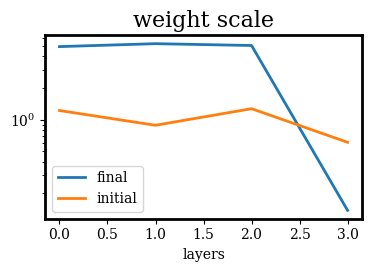

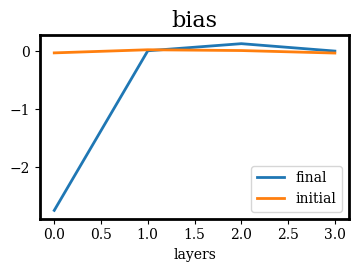

In [15]:
plt.figure(figsize = (4,3))

plt.plot([w_init for w_init, b_init in scale_params], label = 'final')
plt.plot([w_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.yscale('log')
plt.xlabel('layers')
plt.legend()
plt.title('weight scale')
plt.tight_layout()

plt.show()
plt.close()

plt.figure(figsize = (4,3))

plt.plot([b_init for w_init, b_init in scale_params], label = 'final')
plt.plot([b_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.xlabel('layers')
plt.legend()
plt.title('bias')
plt.tight_layout()

plt.show()
plt.close()

In [16]:
fit_model.scaled_net_params = parameter_scaling(fit_model.net_params[:-1], scale_params) + [fit_model.net_params[-1]]

In [17]:
init_fn, update_fn, get_params = optimizers.adam(optimizers.exponential_decay(1e-3, decay_steps = 100, decay_rate = 0.99))

@jit
def step(i, state, batch):
    g = grad(fit_model.loss)(get_params(state), batch)
    return update_fn(i, g, state)

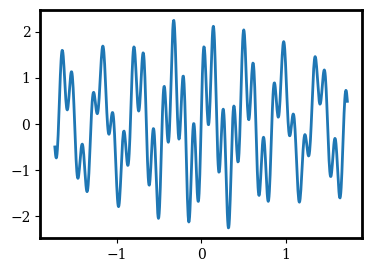

In [49]:
max_freq = 32
N_freq = 4

key = random.PRNGKey(1234)

target_fn = fun_gen(key, max_freq, N_freq)

X = np.linspace(-1,1,800).reshape(-1,1)
Y = target_fn(X)


nIter = 80000

plt.figure(figsize = (4,3))
plt.plot((X - X.mean(0)) / X.std(0), (Y - Y.mean(0)) / Y.std(0))
plt.tight_layout()
plt.savefig(path + f'_data_size_target_{max_freq}.pdf', dpi = 200)
plt.show()
plt.close()

In [61]:
train_errors = []
test_errors = []

init_size = 8

opt_error = jit(lambda opt_states, batch: vmap(fit_model.l2_error, in_axes = [0, None])(vmap(get_params)(opt_states), batch))

data_sizes = 2 ** np.arange(4, 13).astype(int)
for data_size in data_sizes:
    key,_ = random.split(key)

    X_train = random.uniform(key, shape = (data_size, 1), minval = -1, maxval = 1)

    Y_train = target_fn(X_train)
#     Y_train = Y_train + random.normal(random.split(key)[0], shape = Y_train.shape)*Y.std(0)*0.05
    
    mu_X, sigma_X = X_train.mean(0), X_train.std(0)
    X_train = (X_train - mu_X) / sigma_X

    mu_Y, sigma_Y = Y_train.mean(0), Y_train.std(0)
    Y_train = (Y_train - mu_Y) / sigma_Y

    train_batch = (X_train, Y_train)
    
    X_test = (X - mu_X) / sigma_X
    Y_test = (Y - mu_Y) / sigma_Y
    

    key,_ = random.split(key)

    init_paramses = vmap(fit_model.net_init)(random.split(key, init_size))
    scaled_init_paramses = vmap(full_scaling, in_axes = (0, None))(init_paramses, scale_params)

    stacked_init_paramses = tree_multimap(cat_fn, init_paramses, scaled_init_paramses)

    opt_states = vmap(init_fn)(stacked_init_paramses)

    v_step = jit(vmap(step, in_axes = [None, 0, None]))


    pbar = trange(nIter)
    
        
    for i in pbar:
        opt_states = v_step(i, opt_states, train_batch)
        if i % 1000 == 0:
            ell = opt_error(opt_states, train_batch)
            pbar.set_postfix({'Mean train error, Xavier': ell[:init_size].mean(0), 'Mean train error, Scaled': ell[init_size:].mean(0)})
  
    
    train_errors.append(opt_error(opt_states, train_batch))
    test_errors.append(opt_error(opt_states, (X_test, Y_test)))
    print({'Data size': data_size,\
                      'Xavier': f'{test_errors[-1][:init_size].mean():.2e}',\
                      'Scaled': f'{test_errors[-1][init_size:].mean():.2e}'})
    np.save(path + f'_data_size_train_test_errors_{max_freq}.npy', np.array((train_errors, test_errors)))
    

        
train_errors = np.array(train_errors)

test_errors = np.array(test_errors)

  0%|          | 0/80000 [00:00<?, ?it/s]

{'Data size': 16, 'Xavier': '1.74e+00', 'Scaled': '1.58e+00'}


  0%|          | 0/80000 [00:00<?, ?it/s]

{'Data size': 32, 'Xavier': '1.87e+00', 'Scaled': '1.30e+00'}


  0%|          | 0/80000 [00:00<?, ?it/s]

{'Data size': 64, 'Xavier': '1.11e+00', 'Scaled': '1.31e+00'}


  0%|          | 0/80000 [00:00<?, ?it/s]

{'Data size': 128, 'Xavier': '6.28e-01', 'Scaled': '5.94e-01'}


  0%|          | 0/80000 [00:00<?, ?it/s]

{'Data size': 256, 'Xavier': '2.52e-01', 'Scaled': '2.56e-01'}


  0%|          | 0/80000 [00:00<?, ?it/s]

{'Data size': 512, 'Xavier': '4.22e-01', 'Scaled': '8.92e-02'}


  0%|          | 0/80000 [00:00<?, ?it/s]

{'Data size': 1024, 'Xavier': '3.22e-01', 'Scaled': '6.90e-02'}


  0%|          | 0/80000 [00:00<?, ?it/s]

{'Data size': 2048, 'Xavier': '3.27e-01', 'Scaled': '7.15e-02'}


100%|██████████| 80000/80000 [01:28<00:00, 904.91it/s, Mean train error, Xavier=0.38404918, Mean train error, Scaled=0.065044835]

{'Data size': 4096, 'Xavier': '3.83e-01', 'Scaled': '6.45e-02'}


In [62]:
train_errors, test_errors = np.load(path + f'_data_size_train_test_errors_{max_freq}.npy')
sizes = data_sizes[:train_errors.shape[0]]

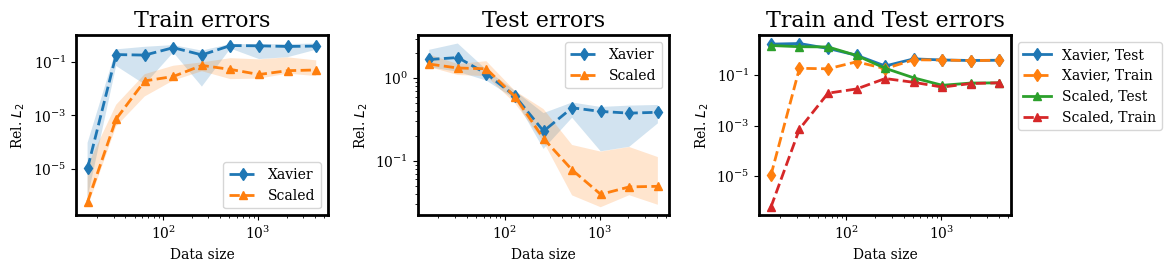

In [63]:
plt.figure(figsize = (12,3))
plt.subplot(1,3,1)
plt.plot(sizes, np.median(train_errors[:,:init_size], axis = 1), marker = 'd', linestyle = '--', label = 'Xavier')
plt.fill_between(sizes, *np.quantile(train_errors[:,:init_size], np.array([0.1, 0.9]), axis = 1), alpha = 0.2)
plt.plot(sizes, np.median(train_errors[:,init_size:], axis = 1), marker = '^', linestyle = '--', label = 'Scaled')
plt.fill_between(sizes, *np.quantile(train_errors[:,init_size:], np.array([0.1, 0.9]), axis = 1), alpha = 0.2)
plt.xlabel('Data size')
plt.ylabel(r'Rel. $L_2$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title('Train errors')
# plt.ylim([5e-3, 1])
plt.tight_layout()
plt.subplot(1,3,2)
plt.plot(sizes, np.median(test_errors[:,:init_size], axis = 1), marker = 'd', linestyle = '--', label = 'Xavier')
plt.fill_between(sizes, *np.quantile(test_errors[:,:init_size], np.array([0.1, 0.9]), axis = 1), alpha = 0.2)
plt.plot(sizes, np.median(test_errors[:,init_size:], axis = 1), marker = '^', linestyle = '--', label = 'Scaled')
plt.fill_between(sizes, *np.quantile(test_errors[:,init_size:], np.array([0.1, 0.9]), axis = 1), alpha = 0.2)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title('Test errors')
plt.xlabel('Data size')
plt.ylabel(r'Rel. $L_2$')
# plt.ylim([5e-3, 1])
plt.tight_layout()

plt.subplot(1,3,3)
plt.plot(sizes, np.median(test_errors[:,:init_size], axis = 1),\
         marker = 'd', label = 'Xavier, Test')
plt.plot(sizes, np.median(train_errors[:,:init_size], axis = 1),\
                  marker = 'd', linestyle = '--', label = 'Xavier, Train')

plt.plot(sizes, np.median(test_errors[:,init_size:], axis = 1),\
         marker = '^', label = 'Scaled, Test')

plt.plot(sizes, np.median(train_errors[:,init_size:], axis = 1),\
         marker = '^', linestyle = '--', label = 'Scaled, Train')

plt.xlabel('Data size')
plt.ylabel(r'Rel. $L_2$')
plt.yscale('log')
plt.xscale('log')
# plt.ylim([5e-3, 1])
plt.title('Train and Test errors')
plt.legend(bbox_to_anchor = [1., 1.])

plt.tight_layout()

plt.savefig(path + f'_data_size_errors_{max_freq}.pdf', dpi = 200)
plt.show()
plt.close()